In [1]:
from Bio         import SeqIO
from collections import Counter
from matplotlib  import pyplot as plt
from scipy.stats import mannwhitneyu

import seaborn as sns
import numpy   as np
import pandas  as pd
import igraph  as ig

import random
import os
import itertools
import multiprocessing
import re

In [2]:
%cd ~/work/clusterEvo/new_tests/archaea/

/nobackup1b/users/thiberio/clusterEvo/new_tests/archaea


In [3]:
minimum_size_groups = []
with open('homolog_groups.list') as description:
    for line in description:
        if not line.startswith('cluster '):
            continue
        tmp_num_proteins, tmp_num_taxa = [int(count) for count in re.search('\ssize=(\d+) taxa=(\d+) file', line).groups()]
        
        if tmp_num_taxa < 10:# or tmp_num_proteins >= tmp_num_taxa * 3:
            continue
        
        tmp_name = line.split('_')[0].replace('cluster ', '')
        minimum_size_groups.append( tmp_name )

In [4]:
len(minimum_size_groups)

1327

In [5]:
graph = ig.Graph.Read_Picklez('coevolving_graph.pkl')

minimum_size_clusters = []
for clst_num in set(graph.vs['louvain']):
    clst_nodes = graph.vs.select(louvain     =clst_num, 
                                 trusted_clst=True)
    
    if len(clst_nodes) >= 10:
        minimum_size_clusters.append(clst_num)
        print( clst_num, len(clst_nodes) )

0 17
1 11
3 12
4 48
5 20
8 13


In [6]:
gbk_files = [filename.replace('.gbk', '')
             for filename in os.listdir('genomes/')
             if filename.endswith('.gbk')]

proteins_per_genome = {accession:[] 
                       for accession in gbk_files}
proteins_per_group  = {}
proteins2group      = {}
proteins2genome     = {}
# for group in graph.vs['name']:
for group in minimum_size_groups:
    proteins_per_group[group] = []
    
    with open(f'minimum_size_groups/{group}.faa') as fasta:
        for protein_id, genome_acc in re.findall('^>(\S+?)\|(\S+?)$', 
                                                 fasta.read(), 
                                                 re.M):
            proteins_per_genome[genome_acc].append(protein_id)
            proteins_per_group[group].append(      protein_id)
            
            proteins2group[protein_id]  = group
            proteins2genome[protein_id] = genome_acc
#     break

proteins2group  = pd.Series(proteins2group)
proteins2genome = pd.Series(proteins2genome)

In [7]:
def get_genomic_dist(feat1, feat2, replicon_length=0):
            
    feat1_name = feat1.qualifiers['protein_id'][0]
    feat2_name = feat2.qualifiers['protein_id'][0]

    start1, end1 = feat1.location.nofuzzy_start, feat1.location.nofuzzy_end
    start2, end2 = feat2.location.nofuzzy_start, feat2.location.nofuzzy_end

    if   end1 < start2:
        linear_distance = start2 - end1
    elif end2 < start1:
        linear_distance = start1 - end2
    elif end1 >= start2 or end2 >= start1:
        return(feat1_name, feat2_name, 0)
    else:
        print(f'{start1}-{end1}\n{start2}-{end2}')
        print('\t*Not expected scenario...')
        
    if not replicon_length:
        return(feat1_name, feat2_name, linear_distance)
            
    else:
        if   end2 >= start1:
            circular_distance = (replicon_length - end2) + start1
        elif end1 >= start2:
            circular_distance = (replicon_length - end1) + start2
        else:
            print('\t*Not expected scenario...')
        
        if linear_distance <= circular_distance:
            return(feat1_name, feat2_name, linear_distance)
        else:
            return(feat1_name, feat2_name, circular_distance)

In [8]:
if not os.path.isfile('genomic_distances_between_homologs.parquet'):
    genomic_distances = pd.DataFrame(columns=['protein1', 'protein2', 'bp_distance'])
    for genome_acc in gbk_files[:]:
        print(genome_acc)
        gbk = SeqIO.parse(f'genomes/{genome_acc}.gbk', 'gb')

        genome_bp_size    = 0
        replicon_proteins = {}
        for source in gbk:
            genome_bp_size += len(source.seq)
            feats           = []
            for feat in source.features:
                if feat.type != 'CDS' or 'pseudo' in feat.qualifiers:
                    continue

                if feat.qualifiers['protein_id'][0] in proteins_per_genome[genome_acc]:
                    feats.append(feat)

            if feats:
                replicon_proteins[source.id] = [feat.qualifiers['protein_id'][0]
                                                for feat in feats]
            feats = np.array(feats)

            pair_indices = np.triu_indices(len(feats), 1)
            if source.annotations['topology'].lower() == 'circular':
                pool_input = zip(feats[pair_indices[0]],
                                 feats[pair_indices[1]],
                                 [len(source.seq)] * pair_indices[0].shape[0])
            else:
                pool_input = zip(feats[pair_indices[0]],
                                 feats[pair_indices[1]])

            pool      = multiprocessing.Pool(processes=20)
            tmp_dists = pool.starmap(get_genomic_dist, 
                                     pool_input)
            pool.close()
            pool.join()

            genomic_distances = genomic_distances.append(pd.DataFrame(columns=['protein1', 
                                                                               'protein2', 
                                                                               'bp_distance'],
                                                                      data   =tmp_dists), 
                                                         ignore_index=True)

        if len(replicon_proteins) > 1:
            tmp_column1 = []
            tmp_column2 = []
            for replicon1, replicon2 in itertools.combinations(replicon_proteins.values(), 2):
                for protein1, protein2 in itertools.product(replicon1, replicon2):
                    tmp_column1.append(protein1)
                    tmp_column2.append(protein2)

            genomic_distances = genomic_distances.append(pd.DataFrame(columns=['protein1', 
                                                                               'protein2', 
                                                                               'bp_distance'],
                                                                      data   =zip(tmp_column1, 
                                                                                  tmp_column2,
                                                                                  [genome_bp_size] * len(tmp_column1) )), 
                                                 ignore_index=True)
    genomic_distances.to_parquet('genomic_distances_between_homologs.parquet')
    genomic_distances.to_csv(    'genomic_distances_between_homologs.tsv', sep='\t')

else:
    genomic_distances = pd.read_parquet('genomic_distances_between_homologs.parquet')

genomic_distances.head()

,protein1,protein2,bp_distance
0,AAL62495.1,AAL62499.1,2085
1,AAL62495.1,AAL62500.1,2754
2,AAL62495.1,AAL62507.1,6845
3,AAL62495.1,AAL62508.1,7773
4,AAL62495.1,AAL62513.1,10926


In [9]:
def add_related_groups(df):
    df.loc[:,'group1'] = df.loc[:,'protein1'].apply(lambda x: 
                                                    proteins2group[x])
    df.loc[:,'group2'] = df.loc[:,'protein2'].apply(lambda x: 
                                                    proteins2group[x])
    
    df.loc[:, 'related_groups'] = df.loc[:, ['group1', 'group2']].apply(lambda x: 
                                                                            frozenset(x), 
                                                                            axis=1
                                                                           )
    
    df.loc[:,'genome'] = df.loc[:, 'protein1'].apply(lambda x: 
                                                     proteins2genome[x])

    return(df)

In [10]:
num_threads       = 15
sub_dfs           = np.array_split(genomic_distances, num_threads)
pool              = multiprocessing.Pool(processes=num_threads)
genomic_distances = pd.concat( pool.map(add_related_groups, sub_dfs) )
pool.close()
pool.join()

In [11]:
genomic_distances.sort_values(by     ='bp_distance', 
                              inplace=True)

genomic_distances.drop_duplicates(subset =['related_groups', 'genome'], 
                                  keep   ='first', 
                                  inplace=True)

genomic_distances.head()

,protein1,protein2,bp_distance,group1,group2,related_groups,genome
7265044,ABU82384.1,ABU82385.1,0,3702,2378,"(2378, 3702)",GCA_000017945.1
1639252,AFU56951.1,AFU56952.1,0,9784,9966,"(9784, 9966)",GCA_000303155.1
1643357,AFU56968.1,AFU56969.1,0,870,869,"(869, 870)",GCA_000303155.1
12456482,AAV47728.1,AAV47729.1,0,999,998,"(998, 999)",GCA_000011085.1
1646623,AFU56978.1,AFU56979.1,0,1334,1333,"(1334, 1333)",GCA_000303155.1


In [ ]:
clst_num       = 4
clst_nodes     = graph.vs.select(louvain     =clst_num, 
                                 trusted_clst=True)['name']
non_clst_nodes = graph.vs.select(louvain_ne  =clst_num, 
                                 louvain_in  =minimum_size_clusters,
                                 trusted_clst=True)['name']

clst_proteins = itertools.chain(*[proteins_per_group[group_name] 
                                  for group_name in clst_nodes])
clst_proteins = list(clst_proteins)

non_clst_proteins = itertools.chain(*[proteins_per_group[group_name] 
                                  for group_name in non_clst_nodes])
non_clst_proteins = list(non_clst_proteins)

within_cluster_distances  = genomic_distances.query(
    'protein1 in @clst_proteins & protein2 in @clst_proteins'
).bp_distance.values

between_cluster_distances = genomic_distances.query(
    '(protein1 not in @clst_proteins & protein2 in @clst_proteins) | '
    '(protein1 in @clst_proteins & protein2 not in @clst_proteins)'
#     '(protein1 in @clst_proteins     & protein2 in @non_clst_proteins) | '
#     '(protein1 in @non_clst_proteins & protein2 in @clst_proteins)'
).bp_distance.values

In [15]:
clst_num      = 4
clst_nodes    = graph.vs.select(louvain=clst_num)['name']

clst_proteins = itertools.chain(*[proteins_per_group[group_name] 
                                  for group_name in clst_nodes])
clst_proteins = list(clst_proteins)

within_cluster_distances  = genomic_distances.query(
    'protein1 in @clst_proteins & protein2 in @clst_proteins'
).bp_distance.values

between_cluster_distances = genomic_distances.query(
    '(protein1 not in @clst_proteins & protein2 in @clst_proteins) | '
    '(protein1 in @clst_proteins & protein2 not in @clst_proteins)'
).bp_distance.values

In [71]:
minimum_size_clusters

[0, 1, 3, 4, 5, 8]

In [76]:
within_cluster_distances  = []
between_cluster_distances = []

evaluated_clusters        = []

for clst_num in set(graph.vs['louvain']):
    evaluated_clusters.append(clst_num)
    
    clst_nodes    = graph.vs.select(louvain=clst_num)['name']
    clst_proteins = itertools.chain(*[proteins_per_group[group_name] 
                                  for group_name in clst_nodes])
    clst_proteins = list(clst_proteins)

    non_clst_nodes    = graph.vs.select(louvain_notin=evaluated_clusters)['name']
    non_clst_proteins = itertools.chain(*[proteins_per_group[group_name] 
                                  for group_name in non_clst_nodes])
    non_clst_proteins = list(non_clst_proteins)

    within_cluster_distances.extend(genomic_distances.query(
        'protein1 in @clst_proteins & protein2 in @clst_proteins'
    ).bp_distance.tolist())

    between_cluster_distances.extend(genomic_distances.query(
        '(protein1 in @clst_proteins     & protein2 in @non_clst_proteins) | '
        '(protein1 in @non_clst_proteins & protein2 in @clst_proteins)'
    ).bp_distance.tolist())
    
within_cluster_distances  = np.array(within_cluster_distances)
between_cluster_distances = np.array(between_cluster_distances)

In [29]:
within_cluster_distances.shape, between_cluster_distances.shape

((299326,), (1454353,))

In [82]:
np.array([window_sizes, inter_intra_ratios]).T

array([[1.00000000e+03, 3.10592264e+00],
       [1.10909091e+04, 1.86626841e+00],
       [2.11818182e+04, 1.58614022e+00],
       [3.12727273e+04, 1.46470459e+00],
       [4.13636364e+04, 1.38798283e+00],
       [5.14545455e+04, 1.33246361e+00],
       [6.15454545e+04, 1.29355757e+00],
       [7.16363636e+04, 1.26930002e+00],
       [8.17272727e+04, 1.24424925e+00],
       [9.18181818e+04, 1.22489007e+00],
       [1.01909091e+05, 1.20602405e+00],
       [1.12000000e+05, 1.19005177e+00],
       [1.22090909e+05, 1.17977518e+00],
       [1.32181818e+05, 1.17151999e+00],
       [1.42272727e+05, 1.16493324e+00],
       [1.52363636e+05, 1.16041576e+00],
       [1.62454545e+05, 1.15488842e+00],
       [1.72545455e+05, 1.14801096e+00],
       [1.82636364e+05, 1.14383469e+00],
       [1.92727273e+05, 1.13840785e+00],
       [2.02818182e+05, 1.13265288e+00],
       [2.12909091e+05, 1.12941430e+00],
       [2.23000000e+05, 1.12415390e+00],
       [2.33090909e+05, 1.12144668e+00],
       [2.431818

In [77]:
inter_intra_ratios        = []
window_sizes              = []
for window_size in np.linspace(1_000, 1_000_000, 100):
    intra_dist = within_cluster_distances[within_cluster_distances   < window_size].shape[0] / within_cluster_distances.shape[ 0]
    inter_dist = between_cluster_distances[between_cluster_distances < window_size].shape[0] / between_cluster_distances.shape[0]
        
    inter_intra_ratios.append(intra_dist/inter_dist)
    window_sizes.append(window_size)
#     print(intra_dist/inter_dist)

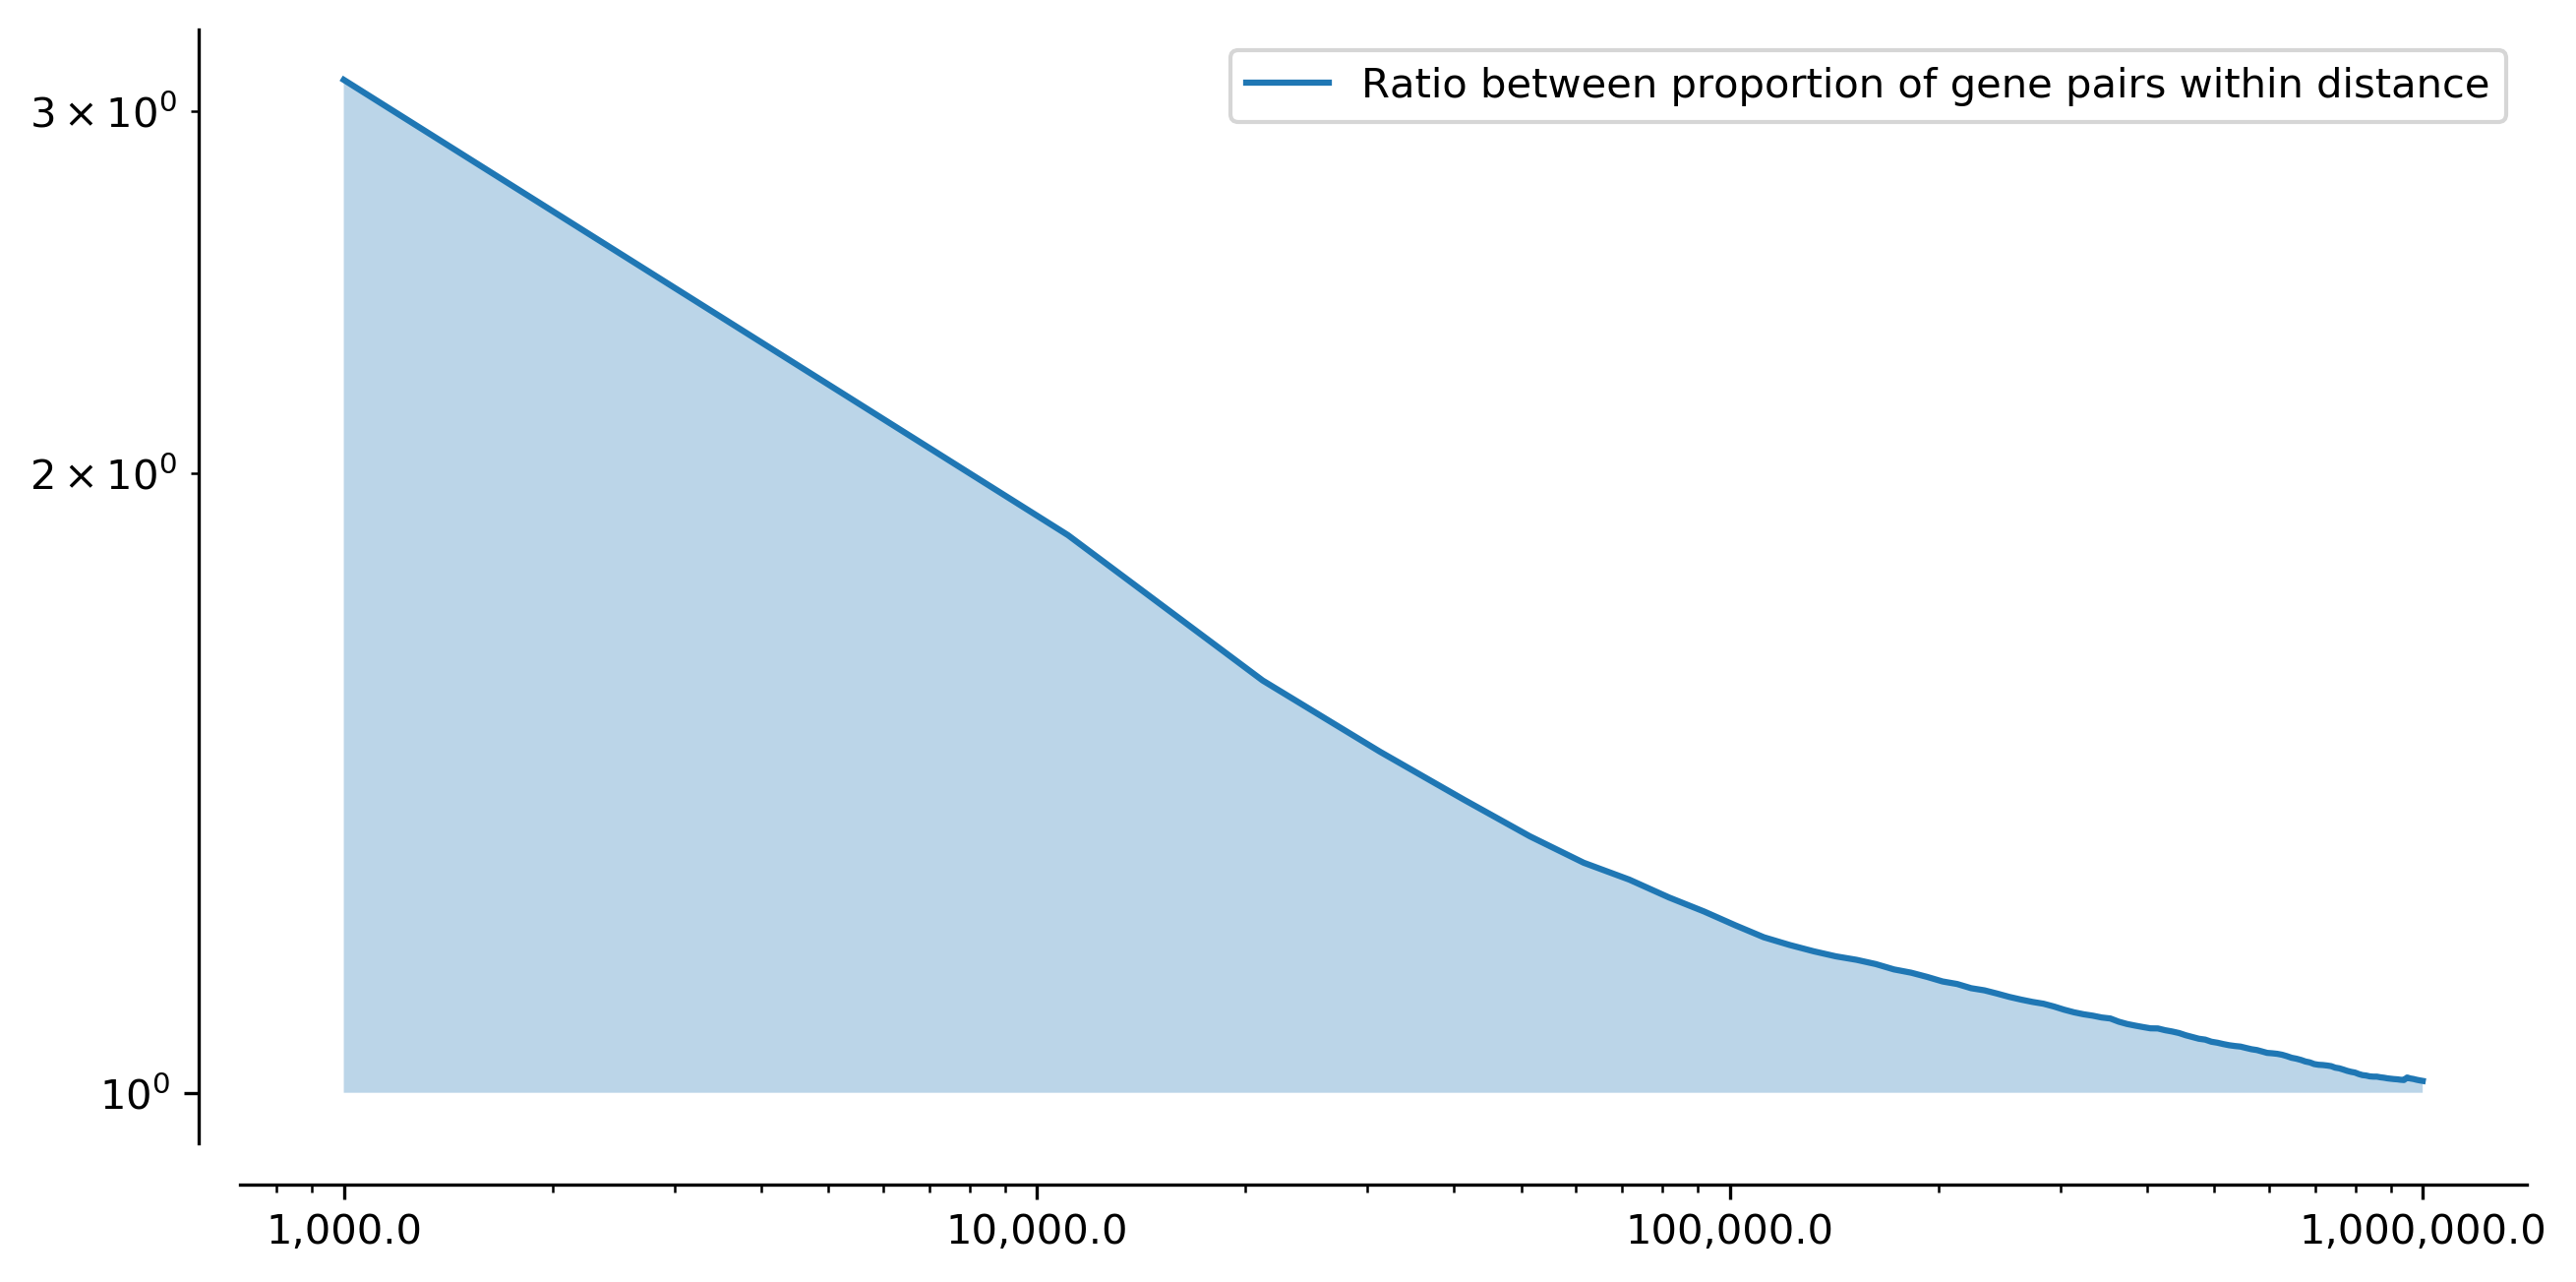

In [97]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# ax.grid()

ax.plot(window_sizes, 
        inter_intra_ratios, 
        label='Ratio between proportion of gene pairs within distance')

ax.fill_between(window_sizes, 
                y1=inter_intra_ratios,
                y2=1,
                alpha=0.3)

# ax.set_xlim(0)
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticklabels([f'{_:,}' for _ in ax.get_xticks()])

sns.despine(offset=10)

In [33]:
%run ~/work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

In [34]:
group_coevol = pd.read_csv('coevolution_indices.tsv',
                           sep='\t', 
                           index_col=0, 
                           dtype=dict(group1=str, 
                                      group2=str))

group_coevol.loc[group_coevol['index'] < 0, 'index'] = 0
group_coevol.loc[:, 'related_groups'] = group_coevol.loc[:, ['group1', 'group2']].apply(lambda x: 
                                                                                        frozenset(x), 
                                                                                        axis=1
                                                                                       )
group_coevol.head()

,group1,group2,Rsquared,braycurtis,index,related_groups
0,19,37,0.412473,0.327273,0.134991,"(19, 37)"
1,19,38,0.516177,0.240000,0.123883,"(19, 38)"
2,19,39,0.408034,0.301887,0.123180,"(19, 39)"
3,19,47,0.553606,0.214286,0.118630,"(19, 47)"
4,19,48,0.635990,0.261905,0.166569,"(19, 48)"


In [35]:
close_gene_pairs          = genomic_distances.query('bp_distance <= 10_000')
distant_gene_pairs        = genomic_distances.query('bp_distance >= 100_000')

close_groups_frequency    =   close_gene_pairs.related_groups.value_counts()
distant_groups_frequency  = distant_gene_pairs.related_groups.value_counts()

neighboring_group_pairs   =    close_groups_frequency[ close_groups_frequency > 21].index
distant_group_pairs       = distant_groups_frequency[distant_groups_frequency > 21].index

neighboring_groups_coevol = group_coevol.query('related_groups in @neighboring_group_pairs')['index'].values
distant_groups_coevol     = group_coevol.query('related_groups in     @distant_group_pairs')['index'].values

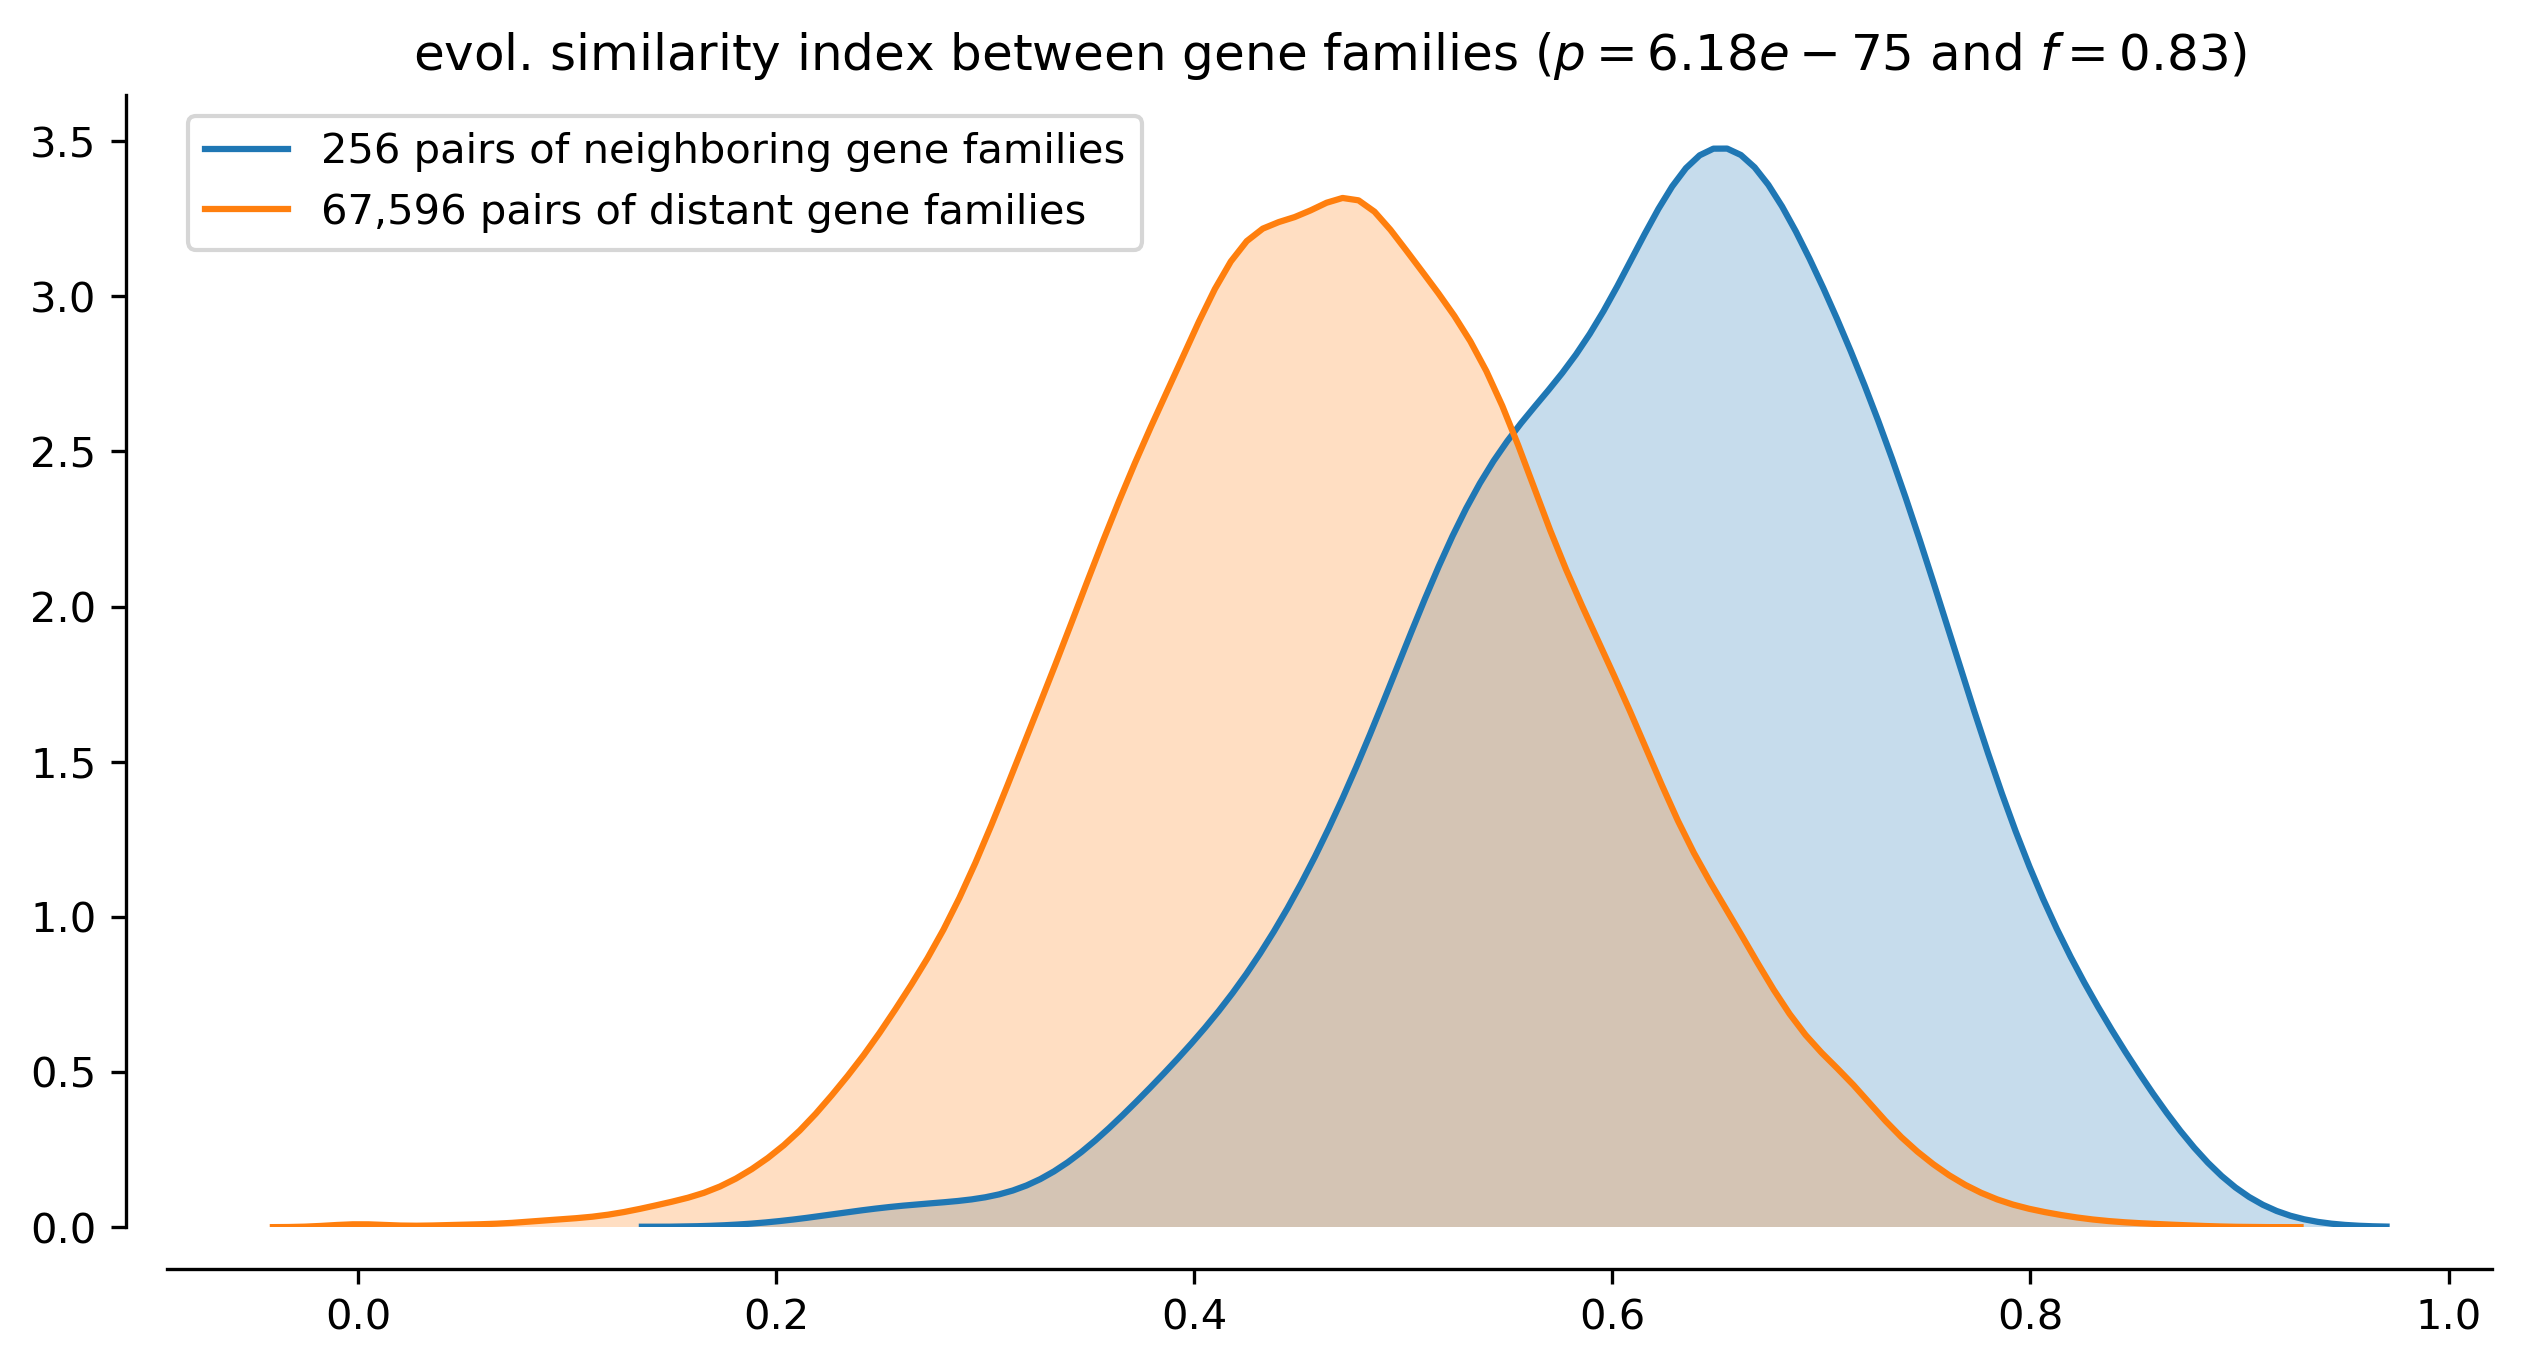

In [40]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

tmp_dists1 = neighboring_groups_coevol[pd.notna(neighboring_groups_coevol)]
sns.kdeplot(tmp_dists1,
            label=f'{len(tmp_dists1):,} pairs of neighboring gene families',    
            shade=True, 
            ax   =ax)

tmp_dists2 = distant_groups_coevol[pd.notna(distant_groups_coevol)]
sns.kdeplot(tmp_dists2, 
            label=f'{len(tmp_dists2):,} pairs of distant gene families', 
            shade=True, 
            ax   =ax);

hypothesis = mannwhitneyu(tmp_dists2,
                          tmp_dists1)
effect_size = cles(tmp_dists2, tmp_dists1)

ax.set_title(f'evol. similarity index between gene families ($p={hypothesis.pvalue:.2e}$ and $f={effect_size:.2f}$)');

sns.despine(offset=10);

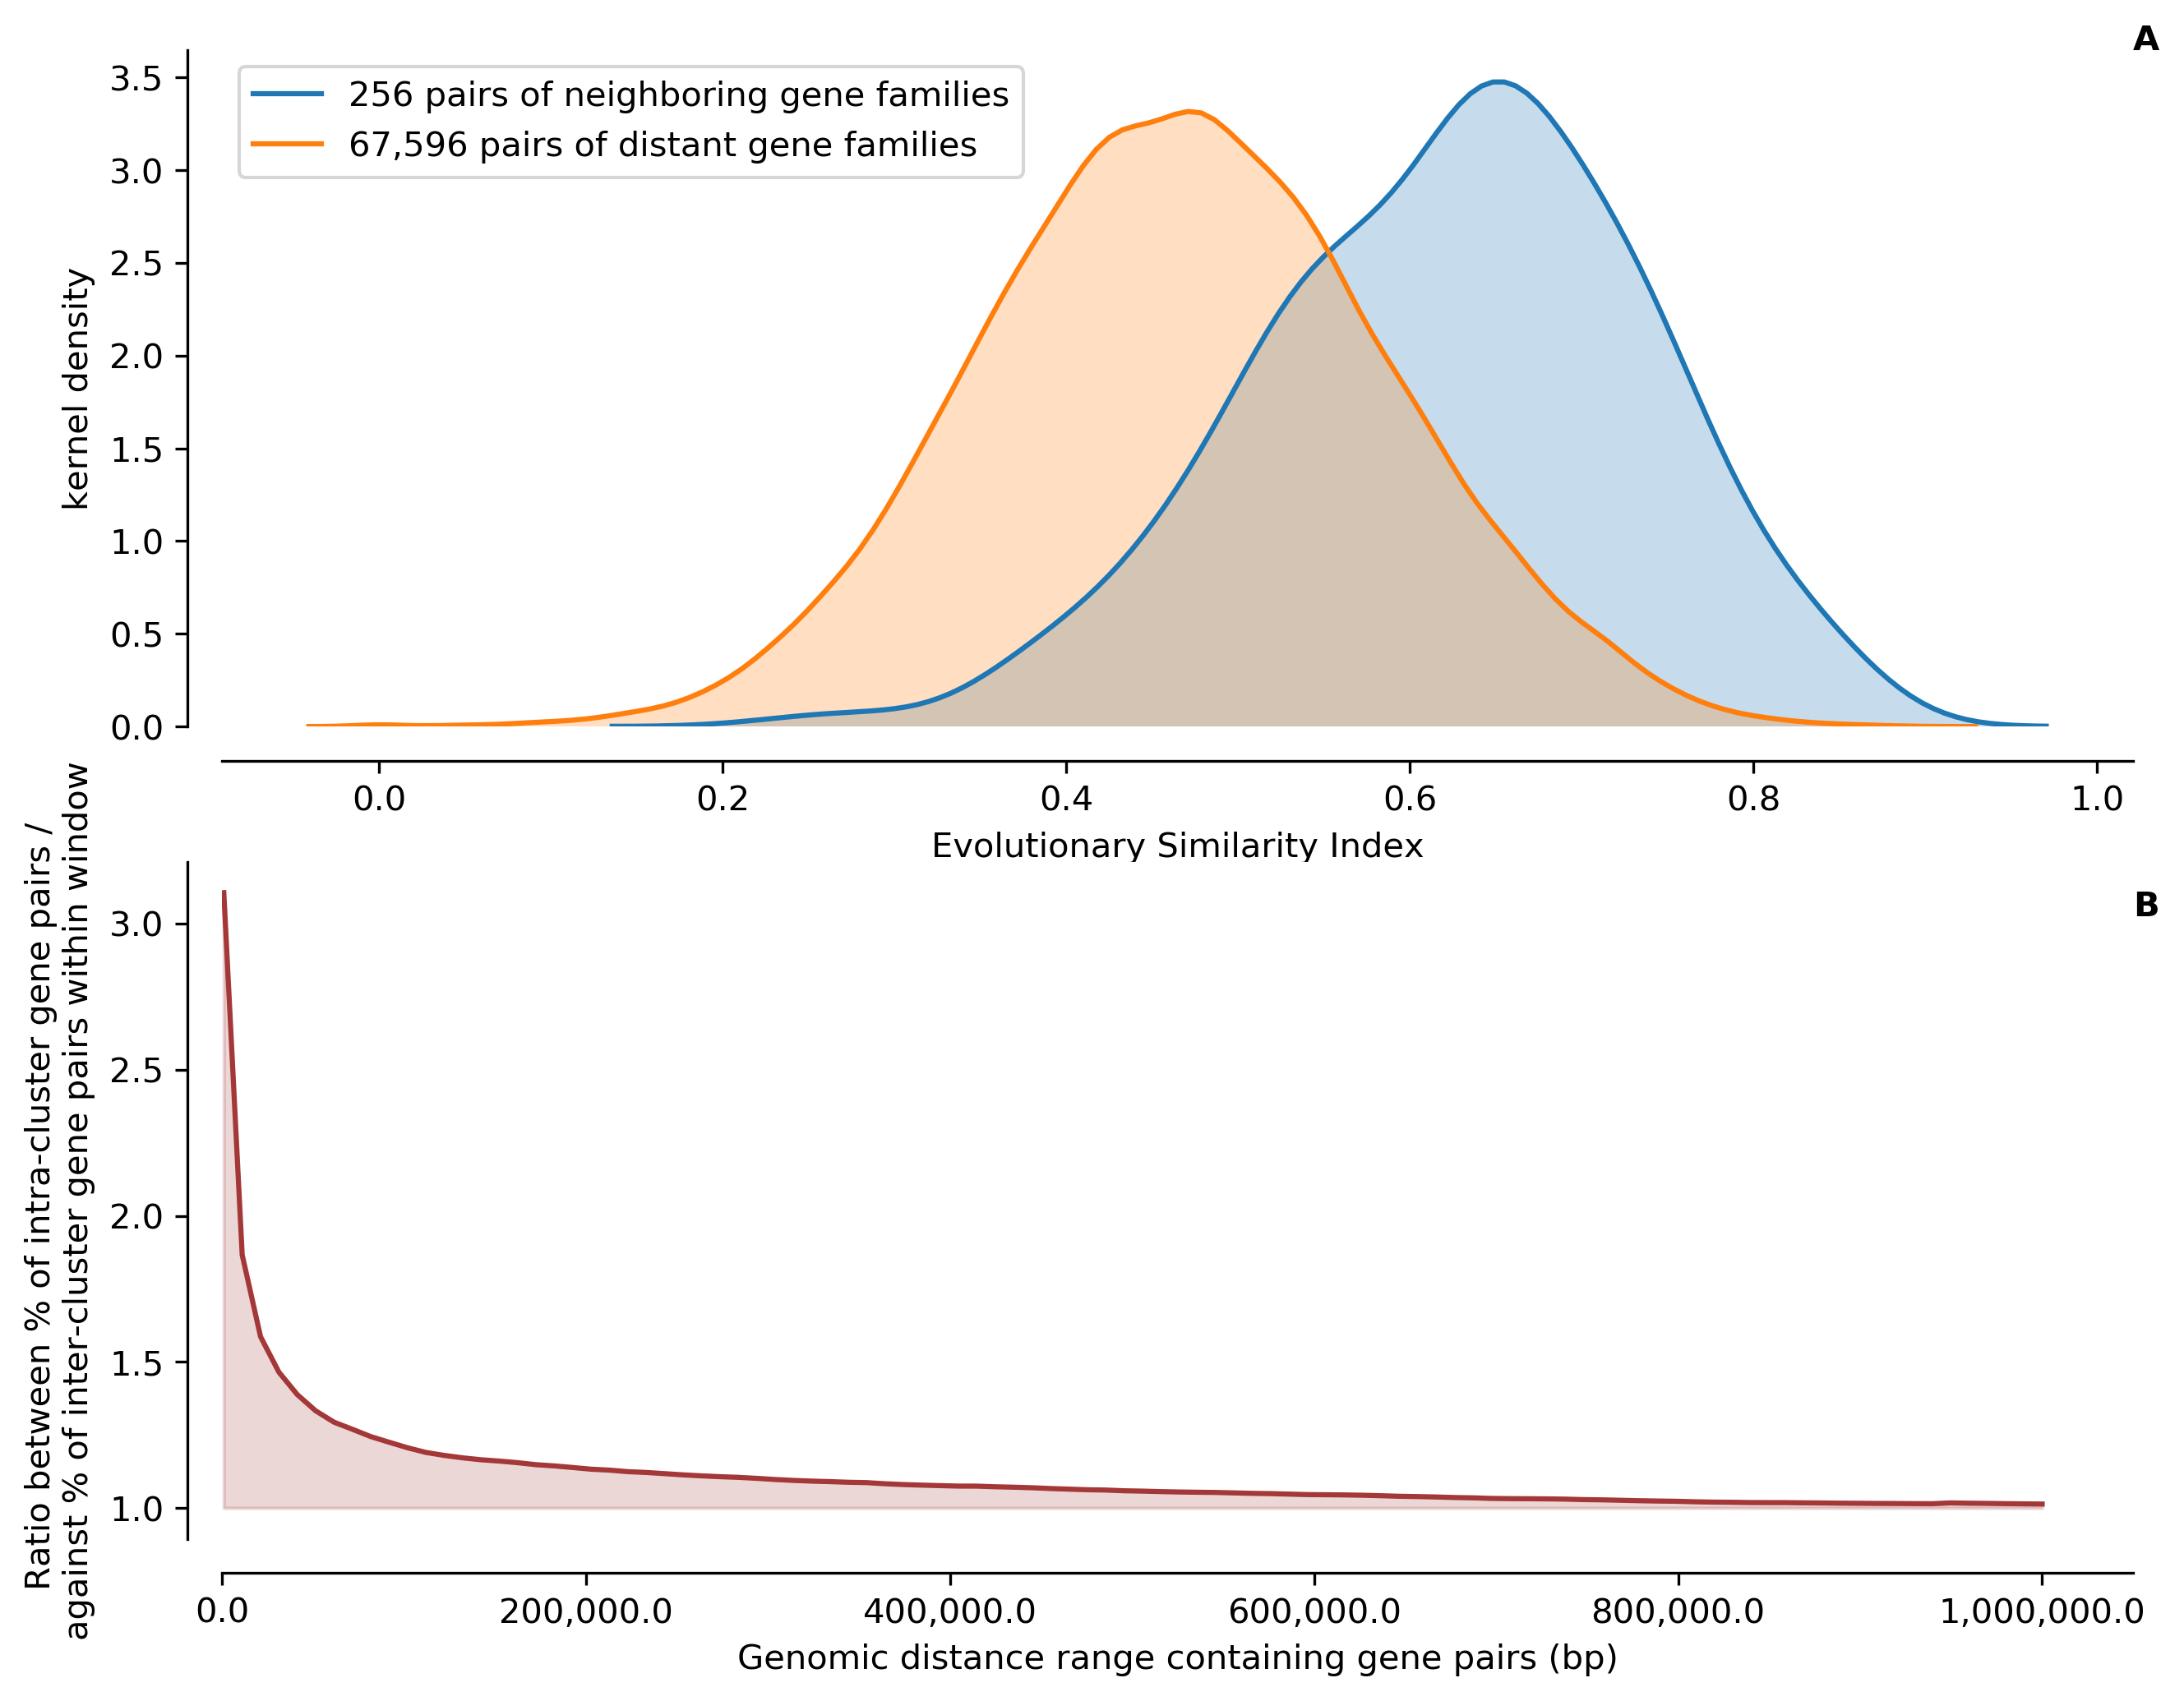

In [109]:
fig, axs = plt.subplots(figsize=(10, 8), dpi=300, nrows=2)

tmp_dists1 = neighboring_groups_coevol[pd.notna(neighboring_groups_coevol)]
sns.kdeplot(tmp_dists1,
            label=f'{len(tmp_dists1):,} pairs of neighboring gene families',    
            shade=True, 
            ax   =axs[0])

tmp_dists2 = distant_groups_coevol[pd.notna(distant_groups_coevol)]
sns.kdeplot(tmp_dists2, 
            label=f'{len(tmp_dists2):,} pairs of distant gene families', 
            shade=True, 
            ax   =axs[0]);

axs[0].text(1, 1, 'A', fontweight='bold', transform=axs[0].transAxes)
axs[0].set_ylabel('kernel density')
axs[0].set_xlabel('Evolutionary Similarity Index')

axs[1].plot(window_sizes, 
            inter_intra_ratios,
            c='#A43737')

axs[1].fill_between(window_sizes, 
                    y1=inter_intra_ratios,
                    y2=1,
                    alpha=0.2,
                    color='#A43737')

axs[1].text(1, 0.92, 'B', fontweight='bold', transform=axs[1].transAxes)
axs[1].set_ylabel('Ratio between % of intra-cluster gene pairs / \nagainst % of inter-cluster gene pairs within window')
axs[1].set_xlabel('Genomic distance range containing gene pairs (bp)')

axs[1].set_xlim(0)
# axs[1].set_ylim(1)
axs[1].set_xticklabels([f'{_:,}' for _ in axs[1].get_xticks()])

sns.despine(offset=10);
# fig.tight_layout()